<a href="https://colab.research.google.com/github/lelouch0204/flow-time-series/blob/main/flow_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install darts

     |████████████████████████████████| 290 kB 15.3 MB/s 
     |████████████████████████████████| 65 kB 3.4 MB/s 
     |████████████████████████████████| 1.4 MB 45.1 MB/s 
     |████████████████████████████████| 9.8 MB 46.0 MB/s 
     |████████████████████████████████| 155 kB 58.1 MB/s 
     |████████████████████████████████| 791 kB 50.3 MB/s 
     |████████████████████████████████| 11.2 MB 75.5 MB/s 
     |████████████████████████████████| 177 kB 48.9 MB/s 
     |████████████████████████████████| 374 kB 54.4 MB/s 
     |████████████████████████████████| 885 kB 52.4 MB/s 
     |████████████████████████████████| 49 kB 4.3 MB/s 
     |████████████████████████████████| 216 kB 67.5 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=a98147ee0c00543e2f41e55fba70eab0042c90960ff023eeb98eb10c416d3abf
  Stored in directory: /root/.cache/pip/wheels/ce/e0/ee/a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
  Created wheel for prophet: filename=prophet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import plotly.express as px
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf 
"""
import darts
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller, Mapper, InvertibleMapper
from darts.dataprocessing import Pipeline
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.utils.timeseries_generation import linear_timeseries
"""

'\nimport darts\nfrom darts import TimeSeries\nfrom darts.models import ExponentialSmoothing\nfrom darts.dataprocessing.transformers import Scaler, MissingValuesFiller, Mapper, InvertibleMapper\nfrom darts.dataprocessing import Pipeline\nfrom darts.metrics import mape\nfrom darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis\nfrom darts.utils.timeseries_generation import linear_timeseries\n'

In [ ]:
data_path = '/content/drive/MyDrive/SOP work/nitrate_nitrite_judson.csv'
df = pd.read_csv(data_path)
df = df[df['units']=='Daily Conc. (mg/L)']
df.head()
df.info()
data = [df["Ts Date"], df['Flow (cfs)'], df['Ts Value']]
headers = ["ts_date", "flow_cfs", 'ts_value']
df_rel = pd.concat(data, axis=1, keys=headers)
df_rel["date"] = pd.to_datetime(df_rel['ts_date'])
df_rel = df_rel.sort_values(by='date')
df_rel.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4383 entries, 2146 to 8765
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Station name        4383 non-null   object 
 1   Station number      4383 non-null   object 
 2   Station type        4383 non-null   object 
 3   Parameter           4383 non-null   object 
 4   Ts Date             4383 non-null   object 
 5   units               4383 non-null   object 
 6   Flow (cfs)          4383 non-null   int64  
 7   Month               4383 non-null   int64  
 8   Qc Desc             4383 non-null   object 
 9   year                4383 non-null   int64  
 10  Site name / number  4383 non-null   object 
 11  Parameter measure   4383 non-null   object 
 12  Var Des             4383 non-null   object 
 13  Var Id              4383 non-null   int64  
 14  Ts Value            4383 non-null   float64
dtypes: float64(1), int64(4), object(10)
memory usage: 54

,ts_date,flow_cfs,ts_value,date
6109,01-01-2008,863,0.473,2008-01-01
6110,01-02-2008,886,0.490,2008-01-02
6111,01-03-2008,887,0.488,2008-01-03
6112,01-04-2008,919,0.509,2008-01-04
6113,01-05-2008,942,0.525,2008-01-05


In [ ]:
series = TimeSeries.from_dataframe(df_rel, time_col='date', value_cols=['flow_cfs', 'ts_value'])

NameError: ignored

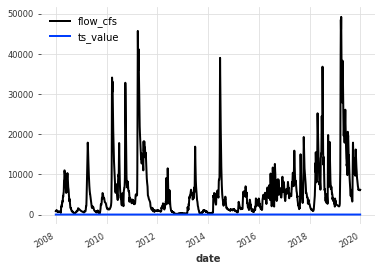

In [ ]:
series.plot()

In [ ]:
def rescale_series(df_series):
    df_std = df_series.std()
    df_mean = df_series.mean()
    df_new = (df_series - df_mean)/(df_std)
    return df_new

In [ ]:
rescale_df = df_rel['date']
rescale_df = pd.concat([rescale_df, rescale_series(df_rel['flow_cfs']), rescale_series(df_rel['ts_value'])], axis=1, keys=['Date', 'Flow_cfs', 'ts_value'])
rescale_df

,Date,Flow_cfs,ts_value
6109,2008-01-01,-0.693118,-0.938314
6110,2008-01-02,-0.689702,-0.933024
6111,2008-01-03,-0.689554,-0.933646
6112,2008-01-04,-0.684801,-0.927111
6113,2008-01-05,-0.681386,-0.922132
...,...,...,...
8761,2019-12-27,0.075711,0.137513
8762,2019-12-28,0.074226,0.137513
8763,2019-12-29,0.080166,0.140625
8764,2019-12-30,0.099472,0.140625


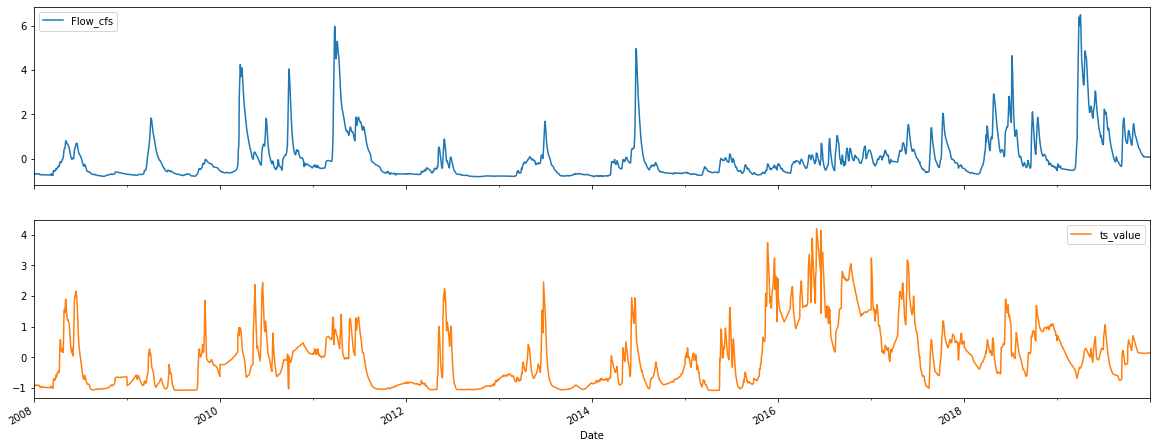

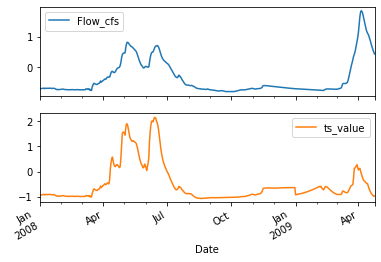

In [ ]:
plot_cols = ['Flow_cfs', 'ts_value']
plot_features = rescale_df[plot_cols]
plot_features.index = rescale_df['Date']
_ = plot_features.plot(subplots=True, figsize=(20, 8))

plot_features = rescale_df[plot_cols][:480]
plot_features.index = rescale_df['Date'][:480]
_ = plot_features.plot(subplots=True)

In [ ]:
train_split = int(0.7*len(rescale_df))
val_split = int(0.9*len(rescale_df))
rescaled_train = rescale_df[:train_split]
rescaled_val = rescale_df[train_split:val_split]
rescale_test = rescale_df[val_split:]
train_split, val_split

(3068, 3944)

In [ ]:
import statsmodels
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [ ]:
for name, column in df_rel.iteritems():
    if column.name == 'flow_cfs' or column.name == 'ts_value':
        adfuller_test(column, name=column.name)
        print('\n')

    Augmented Dickey-Fuller Test on "flow_cfs" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.7957
 No. Lags Chosen       = 4
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ts_value" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.8262
 No. Lags Chosen       = 31
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




## VARIMA


In [ ]:
from darts.models import VARIMA

var_params = {
    "p" : [x for x in range(1, 10)]
}

best_var, best_var_params = VARIMA.gridsearch(
    parameters=var_params,
    series=series[:train_split], 
    val_series=series[train_split:], 
    metric=mape
)

[2021-11-23 18:42:11,374] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'p': 9}
[2021-11-23 18:42:11,374] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'p': 9}


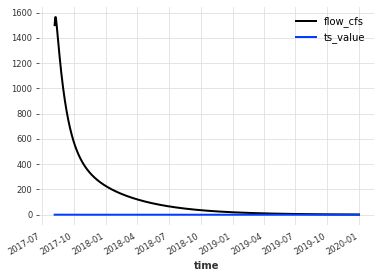

In [ ]:
best_var.fit(series[:train_split])
var_pred_series = best_var.predict(n=test_split)
var_pred_series.plot()

In [ ]:
print(mape(series[train_split:], var_pred_series))
print(best_var_params)

96.65491392371212
{'p': 9}


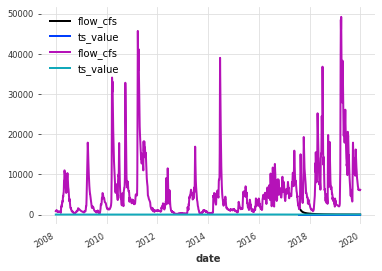

In [ ]:
var_pred_series.plot()
series.plot()

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w1 = WindowGenerator(input_width=6, label_width=1, shift=1, train_df=rescaled_train, val_df=rescaled_val, test_df=rescale_test, label_columns=['Flow_cfs', 'ts_value'])
w1

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Flow_cfs', 'ts_value']

In [ ]:
##CNN model
CONV_WIDTH = 3
LABEL_WIDTH = 6
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH-1)

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

conv_window = WindowGenerator(input_width=INPUT_WIDTH,
                              label_width=LABEL_WIDTH,
                              shift=1,
                              train_df=rescaled_train, val_df=rescaled_val, test_df=rescale_test,
                              label_columns=['Flow_cfs', 'ts_value']
                              )

conv_window

Total window size: 9
Input indices: [0 1 2 3 4 5 6 7]
Label indices: [3 4 5 6 7 8]
Label column name(s): ['Flow_cfs', 'ts_value']